In [1]:
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from truesight.core import TrueSight
from truesight.preprocessing import Preprocessor

In [ ]:
df = pd.read_csv(f"datasets\M5\sales_train_evaluation.csv")
df.drop(["item_id", "dept_id", "cat_id", "store_id", "state_id"], axis = 1, inplace = True)
df = df.melt(id_vars = "id", var_name = "d", value_name = "y")
df = pd.merge(df, pd.read_csv(f"datasets\M5\calendar.csv")[["date", "d"]], on = "d", how = "left")
df.drop(["d"], axis = 1, inplace = True)
df.rename({"date": "ds", "id": "unique_id"}, axis = 1, inplace = True)
df["ds"] = pd.to_datetime(df["ds"])
dates = df["ds"].sort_values().unique()
dates = dates[~((dates == dates[0]) | (dates == dates[-1]))]
df = df[df["ds"].isin(dates)]
df = df.groupby(["unique_id", pd.Grouper(key = "ds", freq = "MS")]).sum().reset_index()
dates = df["ds"].sort_values().unique()

C:\Users\Renan.klehm\AppData\Local\Temp\ipykernel_26536\402851785.py:4: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=df, x='sku', y='zscore', ax=ax, alpha = 0.1, palette='rocket')


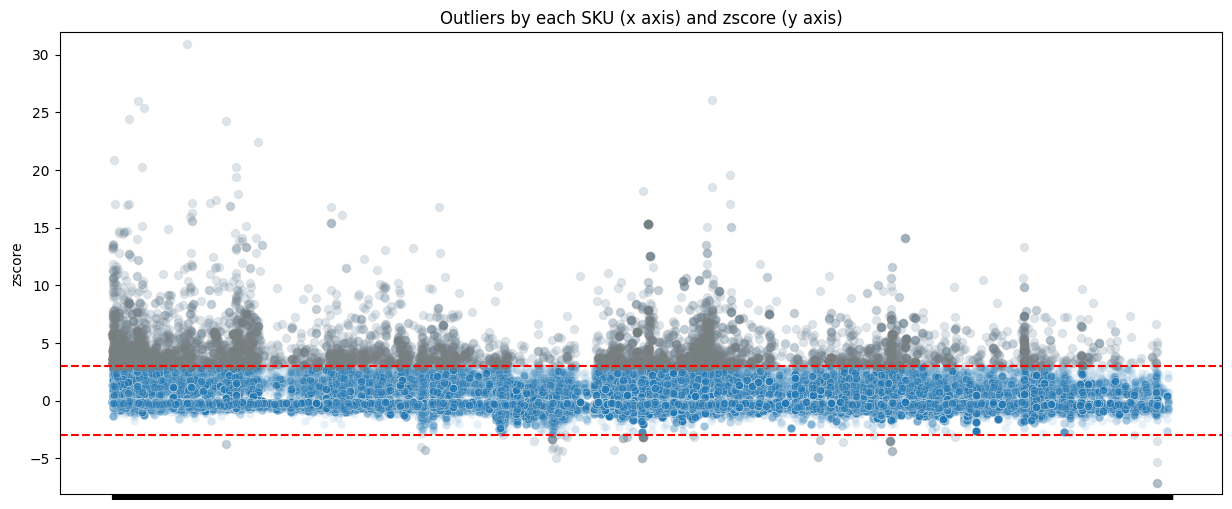

In [81]:
threshold = 3
df['zscore'] = df.groupby(['sku'])['qty_ordered'].transform(lambda x: (x - x.mean()) / x.std())
fig, ax = plt.subplots(figsize=(15,6))
sns.scatterplot(data=df, x='sku', y='zscore', ax=ax, alpha = 0.1, palette='rocket')
ax.axhline(y=threshold, color='r', linestyle='--')
ax.axhline(y=-threshold, color='r', linestyle='--')
dots_outside_threshold = (df['zscore'] > threshold) | (df['zscore'] < -threshold)
ax.scatter(df.loc[dots_outside_threshold, 'sku'], df.loc[dots_outside_threshold, 'zscore'], c='gray', alpha=0.1)
ax.set_ylim(df['zscore'].min() - 1, df['zscore'].max() + 1)
ax.set_title('Outliers by each SKU (x axis) and zscore (y axis)')
ax.set_xlabel('')
ax.set_xticklabels([])
plt.show()

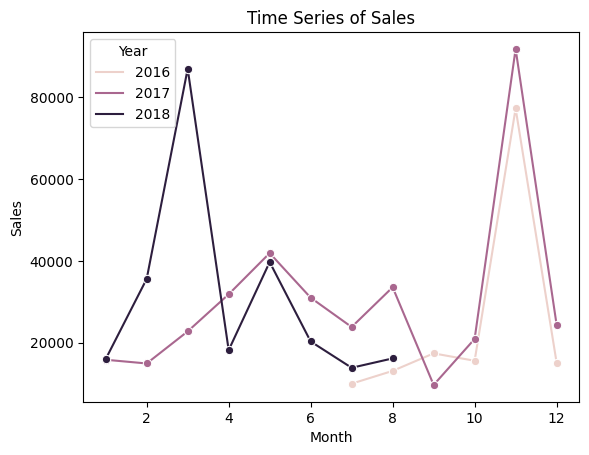

In [79]:
sales_by_month = df.groupby(['year', 'month'])['qty_ordered'].sum().reset_index()

sns.lineplot(data=sales_by_month, x='month', y='qty_ordered', hue='year', marker='o')
plt.title('Time Series of Sales')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.legend(title='Year')
plt.show()

In [23]:
forecast_horizon = 12
season_length = 12

<Axes: xlabel='order_date'>

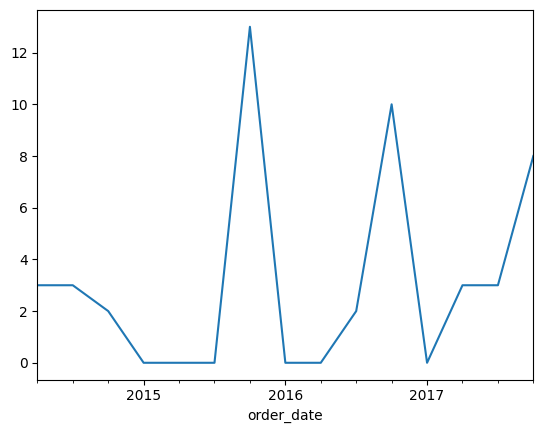

In [30]:
df[df['product_id'] == 'OFF-BI-10000977'].groupby(pd.Grouper(key='order_date', freq='Q'))['quantity'].sum().plot()

In [29]:
df.groupby('product_id')['quantity'].sum().sort_values(ascending=False).head(50)

product_id
TEC-AC-10003832    75
OFF-PA-10001970    70
OFF-BI-10001524    67
FUR-CH-10002647    64
OFF-BI-10002026    64
FUR-TA-10001095    61
TEC-AC-10002049    60
OFF-BI-10004728    59
FUR-CH-10003774    59
TEC-AC-10003038    57
FUR-FU-10001473    57
OFF-ST-10001809    55
FUR-CH-10002880    54
FUR-CH-10004287    53
OFF-PA-10003441    53
OFF-PA-10002377    52
TEC-PH-10001552    52
TEC-AC-10003628    52
FUR-CH-10000454    51
FUR-FU-10004973    51
OFF-LA-10002762    51
FUR-FU-10004270    51
OFF-BI-10003676    51
FUR-CH-10001146    51
OFF-BI-10001718    50
OFF-BI-10000301    50
OFF-BI-10000546    50
TEC-AC-10004510    50
OFF-ST-10000563    50
OFF-AR-10004078    49
TEC-AC-10002473    49
OFF-BI-10002012    49
OFF-ST-10001526    49
OFF-ST-10001490    49
OFF-BI-10003982    48
OFF-BI-10001757    48
OFF-BI-10000545    48
OFF-PA-10000357    48
OFF-FA-10002280    47
OFF-BI-10000174    47
OFF-BI-10000977    47
OFF-BI-10001597    47
OFF-BI-10002082    47
FUR-TA-10001039    47
OFF-ST-10003716    47

In [10]:
preprocessor = Preprocessor(
    df=df,
    date_freq = 'MS', # Frequency of the time series, the dataset will be aggregated to this frequency
    date_col='order_date', # Column with date
    target_col='quantity', # Column to forecast
    id_col=['product_id'], # Columns that identify each time series, in this case, we will forecast sales for each product
    category_cols=['region', 'state', 'category', 'sub_category', 'product_id', 'product_names'], # Categorical columns that do not change over time
    descriptors_cols=['city', 'ship_mode', 'custumer_name', 'segment'], # String columns that change over time
    verbose=True,
    multi_category_warning=False # Some products have multiple descriptions
)

c:\Users\Renan.klehm\Documents\Python\true-sight\truesight\preprocessing.py:39: UserWarning: No GPU detected. When using categories, the model will use a half-transformer architecture. This will be slow on CPU.
  warnings.warn(
c:\Users\Renan.klehm\Documents\Python\true-sight\truesight\preprocessing.py:50: UserWarning: No GPU detected. When using descriptors, the model will use a half-transformer architecture. This will be slow on CPU.
  warnings.warn(
100%|██████████| 8242/8242 [00:19<00:00, 418.56it/s]


In [11]:
from statsforecast.models import SeasonalNaive, AutoETS
from sklearn.linear_model import LinearRegression
from truesight.models import AdditiveDecomposition
from truesight.utils import ModelWrapper

models = [
    ModelWrapper(LinearRegression, horizon=forecast_horizon, season_length=season_length, alias="LinearRegression"), 
    ModelWrapper(SeasonalNaive, horizon=forecast_horizon, season_length=season_length), 
    ModelWrapper(AutoETS, horizon=forecast_horizon, season_length=season_length),
    ModelWrapper(AdditiveDecomposition, horizon=forecast_horizon, season_length=season_length)
]

train_dataset, val_dataset = preprocessor.make_dataset(
    forecast_horizon=forecast_horizon,
    train_split=0.8,
    models=models,
    fallback_model=models[0],
    verbose=True,
    nan_warnings=False # When statistical forecasters fail, they return NaN
)

c:\Users\Renan.klehm\AppData\Local\Programs\Python\Python310\lib\site-packages\statsforecast\core.py:21: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
100%|██████████| 1649/1649 [01:15<00:00, 21.77it/s]


In [12]:
train_dataset.save('train_dataset')
val_dataset.save('val_dataset')

In [13]:
from truesight.containers import Dataset
teste = Dataset.load('train_dataset.pkl')

In [20]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
ts = TrueSight(
    train_dataset, 
    filter_size = 64, 
    n_encoder_layers = 2, 
    n_encoder_heads = 4, 
    context_size = 256, 
    hidden_size = 512, 
    dropout_rate = 0.1
)
ts.compile(optimizer=optimizer, loss='mse')
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience = 10, restore_best_weights = True, monitor = "val_loss"),
    tf.keras.callbacks.ReduceLROnPlateau(monitor = "val_loss", factor = 0.5, patience = 3, verbose = False),
]
ts.fit(
    train_dataset = train_dataset,
    val_dataset = val_dataset,
    batch_size = 128, 
    epochs = 50, 
    verbose = True, 
    callbacks = callbacks,
)
ts.plot_training_history()

Epoch 1/50
 8/52 [===>..........................] - ETA: 1:31 - loss: 1.4375